In [1]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import word_tokenize,sent_tokenize,Text,PorterStemmer,WordNetLemmatizer,pos_tag
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import networkx as nx
import math
import matplotlib.pyplot as plt
import spacy
from spellchecker import SpellChecker
import collections as clt
import time

In [2]:
df = pd.read_csv('reviewsv7.csv')
plt.rcParams["figure.figsize"] = (10,7) #defining size of plots
sp = spacy.load('en_core_web_sm')

In [3]:
df['Text'] = df['Text'].str.lower().str.replace("'s",'').str.replace("'",'').str.replace('-','').str.replace('(',')').str.replace(')','').str.replace(',','').str.replace('.','')
print(df['Text'].head(10))

0    i originally bought chaosphere in late 2000 an...
1    a midpoint between carcass early grind albums ...
2    im not hardcore into metal at all really but i...
3    this is not a new album but in fact five album...
4    ive been trying for months to come up with an ...
5    andromeda extension of the wish clearly one of...
6    to start off i must say that i did not always ...
7    psycroptic  the isle of disenchantment self re...
8    absolute steel  the fair bitch project edgerun...
9    purgation  realm of the dead mcdself released ...
Name: Text, dtype: object


In [4]:
words = {}#dictionary of sets
albums = {}
#stemmer = PorterStemmer() #faster
#stemmer = WordNetLemmatizer() #slower but more accurate
a = time.time()
spell = SpellChecker()
N_albums = len(set(df.Release))
all_stopwords = sp.Defaults.stop_words
for i in range(5000):
    text = set(pos_tag(word_tokenize(df.Text[i])))
    album = df.Release[i]
    if album not in albums:
        albums[album] = set()
    for word,tag in text:
        word = word.lower()
        if word.isalpha() and len(word) > 4 and tag == 'JJ' and word not in all_stopwords and len(spell.unknown([word])) == 0:
            if word not in words:
                words[word] = set()
            words[word].add(album)
            albums[album].add(word) 
print(len(words),time.time()-a)

6262 114.54868006706238


In [5]:
idf_list = [math.log10(N_albums/len(words[word])) for word in words]

In [6]:
prop = [N_albums/len(words[word]) for word in words]

In [27]:
temp = sorted(idf_list)

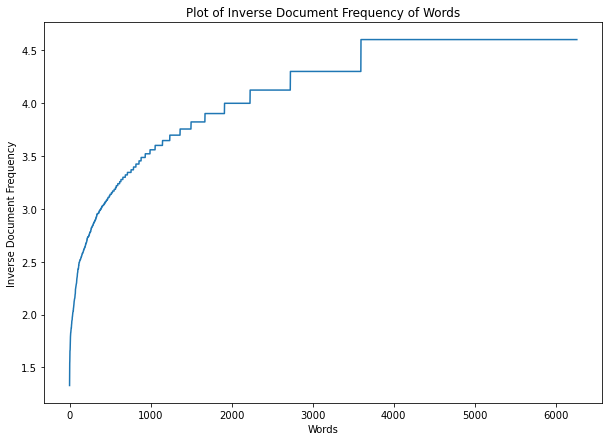

In [31]:
plt.title('Plot of Inverse Document Frequency of Words')
plt.ylabel('Inverse Document Frequency')
plt.xlabel('Words')
plt.plot(temp)
plt.savefig('/images/Plot of Inverse Document Frequency of Words.png')

In [25]:
temp1 = sorted([((N_albums/len(words[word])),word) for word in words])

In [26]:
temp1[-100:]

[(39624.0, 'vibrato'),
 (39624.0, 'vicarious'),
 (39624.0, 'viciousness'),
 (39624.0, 'victimless'),
 (39624.0, 'victoria'),
 (39624.0, 'videos'),
 (39624.0, 'vigilante'),
 (39624.0, 'ville'),
 (39624.0, 'vinci'),
 (39624.0, 'vindictive'),
 (39624.0, 'vinny'),
 (39624.0, 'violently'),
 (39624.0, 'virulent'),
 (39624.0, 'vision'),
 (39624.0, 'vocabulary'),
 (39624.0, 'vodka'),
 (39624.0, 'voice'),
 (39624.0, 'voiced'),
 (39624.0, 'volcanic'),
 (39624.0, 'voluntary'),
 (39624.0, 'vomit'),
 (39624.0, 'vomited'),
 (39624.0, 'waffen'),
 (39624.0, 'wakeman'),
 (39624.0, 'waldemar'),
 (39624.0, 'wallis'),
 (39624.0, 'wallow'),
 (39624.0, 'wallowing'),
 (39624.0, 'wandering'),
 (39624.0, 'wanderlust'),
 (39624.0, 'wanted'),
 (39624.0, 'warbling'),
 (39624.0, 'warlock'),
 (39624.0, 'warman'),
 (39624.0, 'warmly'),
 (39624.0, 'warning'),
 (39624.0, 'warped'),
 (39624.0, 'warrant'),
 (39624.0, 'warren'),
 (39624.0, 'wartime'),
 (39624.0, 'warwick'),
 (39624.0, 'washy'),
 (39624.0, 'waster'),
 (39

In [11]:
G = nx.Graph() #network of words
B = nx.Graph() #bipartite

for word in words:
    for album in words[word]:
        B.add_edge(word,album + 'A')
edges = {}
albummp = {}
for word in words:
    for album in B.adj[word]:
        for word1 in B.adj[album]:
            if word != word1:
                if (word,word1) in edges:
                    edges[(word,word1)] += 1
                    albummp[(word,word1)].add(album)
                elif (word1,word) in edges:
                    edges[(word1,word)] += 1
                    albummp[(word1,word)].add(album)
                else:
                    edges[(word,word1)] = 1
                    albummp[(word,word1)] = set()
                    albummp[(word,word1)].add(album)
for edge in edges:
    G.add_edge(edge[0], edge[1], weight = edges[edge]/2, album = albummp[edge])#because double counted

print(len(G.nodes()))
                    

6262


In [12]:
#calculating similarity between two nodes which share an edge (else default is zero).
#By using each edge, this method cuts down time complexity from O(N^2) to O(E)
def calc_sim(Graph):
    for u,v in Graph.edges():
        #similarity = 2*overlap/sum of degrees of u and v
        sum_of_degrees = Graph.degree(u,weight = 'weight')+Graph.degree(v,weight = 'weight')
        common_edges = Graph[u][v]['weight']
        Graph[u][v]['similarity'] = (2*common_edges)/sum_of_degrees #is this the best way?
        #G[u][v]['similarity'] = common_edges/(sum_of_degrees - common_edges)
    return Graph

In [13]:
G = calc_sim(G)

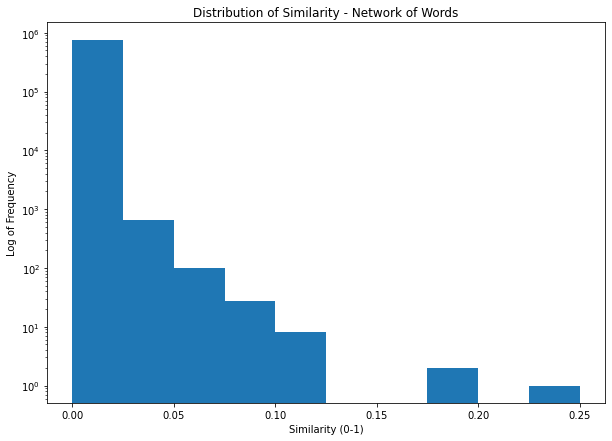

In [14]:
sim_score = [G[u][v]['similarity'] for u,v in G.edges()]
#print(weights)
plt.title('Distribution of Similarity - Network of Words')
plt.xlabel('Similarity (0-1)')
plt.ylabel('Log of Frequency')
#print(min(sim_score))
plt.hist(sim_score, log = True)#specify the number of bins -> 
plt.savefig("Distribution of Similarity - Network of Words.png")
plt.show()

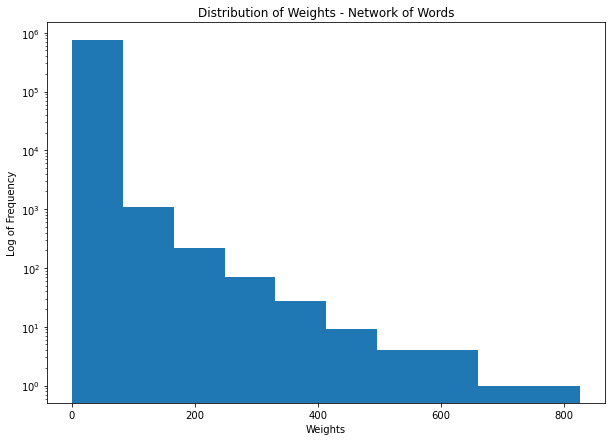

In [15]:
#Assigning weights based on frequency
weights = [G[u][v]['weight'] for u,v in G.edges()]
plt.title('Distribution of Weights - Network of Words')
plt.xlabel('Weights')
plt.ylabel('Log of Frequency')
plt.hist(weights, log = True)
plt.savefig("Distribution of Weights - Network of Words.png")
plt.show()

In [16]:
nx.number_connected_components(G)

1

In [17]:
GC = G 

In [18]:
def cluster(sim):
    #this function generates a graph which is a collection of subgraphs from the original graph
    #after removing all edges with similarity < sim, where sim is to be determined
    #to generate full graph, used for point query
    GC_split = nx.Graph()
    GC_split.add_nodes_from(GC.nodes())
    for u,v in GC.edges():
        if GC[u][v]['similarity'] >= sim:
            GC_split.add_edge(u,v)
            GC_split[u][v]['weight'] = GC[u][v]['weight']
            GC_split[u][v]['similarity'] = GC[u][v]['similarity']
            GC_split[u][v]['album'] = GC[u][v]['album']
    return GC_split

def cluster_fast(sim):
    #a faster version of cluster function, but without edge attributes, for computational purposes only
    GC_split = nx.Graph()
    GC_split.add_nodes_from(GC.nodes())
    for u,v in GC.edges():
        if GC[u][v]['similarity'] >= sim:
            GC_split.add_edge(u,v)
    return GC_split

def components(Graph):
    #returns a list connected components of a graph (a list of lists of nodes in each connected component)
    return list(nx.connected_components(Graph))

def getSize(Graph):
    #returns a list of the size of disconnected subgraphs in a graph
    return [len(x) for x in list(nx.connected_components(Graph))]

def entropy(sim, Graph = nx.Graph()):
    #can be used both for range and point query
    #calculates the Shannon Entropy of a graph
    #if input is a graph instead of similarity value, set sim = -1
    sum = 0
    if sim == -1:#used by range function entropy_range
        clusters = components(Graph)
    else:#used individually
        clusters = components(cluster_fast(sim))
    N = len(GC.nodes())
    for comp in clusters:
        P = len(comp)/N #P is the probability of a node being in a particular component/cluster
        sum += -1*P*math.log10(P)
    return sum

def entropy_range(sim_x, isShannon = False):
    #runs in linear time, but needs to be initialised from largest to smallest similarity
    #takes in a range of values and adds edges individually from greatest to smallest similarity
    #used for range query
    #isShannon is a boolean which is True when finding Shannon Entropy and False when finding Cluster Entropy
    #can be used for both types of entropy by specifying boolean
    #range query reduces run time as graph is only constructed once
    #returns list of entropy values
    pos = 0
    GC_split = nx.Graph()
    GC_split.add_nodes_from(GC.nodes())
    edges = []
    for u,v in GC.edges():
        edges.append((GC[u][v]['similarity'],u,v))
    edges.sort(reverse = True)
    ret = []
    for sim in sim_x:
        for i in range(pos,len(edges)):
            edgesim, u, v = edges[i]
            if edgesim >= sim:
                GC_split.add_edge(u,v)
            else:
                break
        pos = i
        if isShannon:
            ret.append(entropy(-1,GC_split))
        else:
            ret.append(clusterentropy(-1,GC_split))
    ret.reverse()
    return ret

def clusterentropy(sim, Graph = nx.Graph()):
    #can be used both for range and point query
    #set sim = -1 if input is a graph
    if sim == -1:#used by range function entropy_range
        freq = clt.Counter(getSize(Graph))
    else:#used individually
        freq = clt.Counter(getSize(cluster_fast(sim)))
    sum = 0
    N = len(GC.nodes())
    for item in freq:
        P = item*freq[item]/N
        sum += -1*P*math.log10(P) # P is the probability of a cluster having a particular size X (X = item in this case)
    return sum

def entropy_rangemax(sim_x):
    #runs in linear time, but needs to be initialised from largest to smallest similarity
    #takes in a range of values and adds edges individually from greatest to smallest similarity
    #used for range query
    #Different from entropy_range
    #This returns the maximum entropy and the similarity value at which cluster entropy is maximum
    pos = 0
    GC_split = nx.Graph()
    GC_split.add_nodes_from(GC.nodes())
    edges = []
    for u,v in GC.edges():
        edges.append((GC[u][v]['similarity'],u,v))
    edges.sort(reverse = True)
    bestsim = -1
    maxi = -1
    for i1, sim in enumerate(sim_x):
        for i in range(pos,len(edges)):
            edgesim, u, v = edges[i]
            if edgesim >= sim:
                GC_split.add_edge(u,v)
            else:
                break
        pos = i
        x = clusterentropy(-1,GC_split)
        if x > maxi:
            maxi = x
            bestsim = sim
    return maxi,bestsim

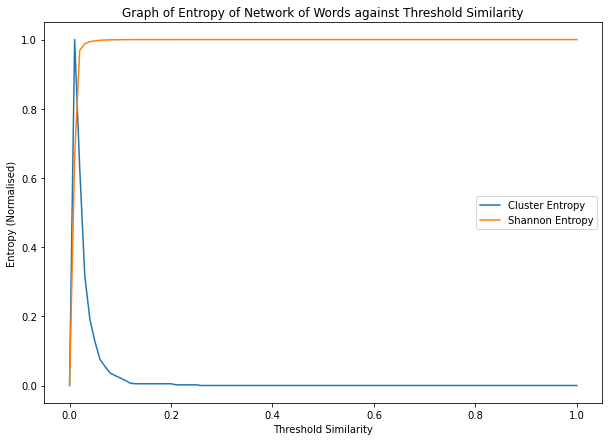

In [19]:
sim_x = [0.01*x for x in range(101)] 
sim_y = entropy_range(reversed(sim_x), True)
max_y = max(sim_y)
sim_y = [item/max_y for item in sim_y]
sim_y1 = entropy_range(reversed(sim_x))
max_y1 = max(sim_y1)
sim_y1 = [item/max_y1 for item in sim_y1]
#print(sim_y)
#sim_x = 0.04*np.array(range(0,26))
plt.title('Graph of Entropy of Network of Words against Threshold Similarity')
plt.xlabel('Threshold Similarity')
plt.ylabel('Entropy (Normalised)')
plt.plot(sim_x,sim_y1, label = 'Cluster Entropy')
plt.plot(sim_x,sim_y, label = 'Shannon Entropy')
plt.legend()
plt.savefig('Graph of Entropy of Network of Words against Threshold Similarity')
plt.show()

In [20]:
#Based on graph, calculate similarity that gives maximum certainty

#Searches with precision of 0.01 in entire range of similarity from 0-1
sim_x = [0.01*x for x in range(101)]#reversed
maxi, sim = entropy_rangemax(reversed(sim_x))
print("Maximum Cluster Entropy:",maxi," when Similarity =",sim)

#Searches with precision of 0.001 within new range based on previous search
sim_x = [0.001*x + sim for x in range(-10,10)]
maxi, sim = entropy_rangemax(reversed(sim_x))
print("Maximum Cluster Entropy:",maxi," when Similarity =",sim)

#Searches with precision of 0.0001 within new range based on previous search (if needed)
sim_x = [0.0001*x + sim for x in range(-10,10)]
maxi, sim = entropy_rangemax(reversed(sim_x))
print("Maximum Cluster Entropy:",maxi," when Similarity =",sim)

#Searches with precision of 0.00001 within new range based on previous search (if needed)
sim_x = [0.00001*x + sim for x in range(-10,10)]
maxi, sim = entropy_rangemax(reversed(sim_x))
print("Maximum Cluster Entropy:",maxi," when Similarity =",sim)
#Therefore, optimal similarity value is determined to be 0.0593
optsim = sim #this value is determined for when posScore = 75
#when posScore = 83 at 50th percentile, optsim = 0.67
print(optsim,maxi)

Maximum Cluster Entropy: 0.654150694611884  when Similarity = 0.01
Maximum Cluster Entropy: 0.9103653032342353  when Similarity = 0.012
Maximum Cluster Entropy: 0.9134769110849205  when Similarity = 0.0118
Maximum Cluster Entropy: 0.9134769110849205  when Similarity = 0.01183
0.01183 0.9134769110849205


In [21]:
DG = cluster(optsim)#disjointed graph (i.e. after removing edges with similarity < optsim )
comp = components(DG)
comp = [item for _,item in sorted([(len(x),x) for x in comp],reverse = True)]

In [22]:
tmp = clt.Counter(getSize(DG))
print(sorted([(x,tmp[x]) for x in tmp], reverse = True))

[(327, 1), (119, 1), (83, 1), (50, 1), (44, 2), (41, 1), (40, 1), (39, 1), (30, 1), (28, 1), (26, 2), (24, 2), (23, 1), (22, 2), (21, 1), (18, 3), (17, 1), (16, 1), (15, 6), (14, 3), (13, 3), (12, 8), (11, 1), (10, 3), (9, 8), (8, 9), (7, 12), (6, 22), (5, 34), (4, 53), (3, 93), (2, 232), (1, 3349)]


In [23]:
print(len(comp[6]))

41
